## Data Utilities

This notebook guides one through the following tasks:

1. Reading the image, segmentation mask, and centroid annotation.
2. Processing them to a standard orientation and spacing.
3. Visualising them. 

In [1]:
## imports

# libraries
import os
import numpy as np
import nibabel as nib
import nibabel.orientations as nio
import matplotlib.pyplot as plt

# custom
from data_utilities import *

### 1. Load a datasample: image, mask, and centroid JSON 

In [2]:
## paths

# data directory
directory = os.path.join(os.getcwd(),'sample')

# load files
img_nib = nib.load(os.path.join(directory,'sub-verse004_ct.nii.gz'))
msk_nib = nib.load(os.path.join(directory,'sub-verse004_seg-vert_msk.nii.gz'))
ctd_list = load_centroids(os.path.join(directory,'sub-verse004_seg-subreg_ctd.json'))

### 2. Check the image orientation, spacing, and the centroid coordinates out. 

Note: The centroids are in the same orientation and spacing as the image.

In [3]:
#check img zooms 
zooms = img_nib.header.get_zooms()
print('img zooms = {}'.format(zooms))

#check img orientation
axs_code = nio.ornt2axcodes(nio.io_orientation(img_nib.affine))
print('img orientation code: {}'.format(axs_code))

#check centroids
print('Centroid List: {}'.format(ctd_list))

img zooms = (1.0, 1.0, 2.000296)
img orientation code: ('P', 'I', 'R')
Centroid List: [('P', 'I', 'R'), [16, 79.1, 40.9, 32.3], [17, 79.3, 63.4, 32.2], [18, 76.0, 88.6, 32.1], [19, 70.6, 117.3, 31.6], [20, 63.2, 141.9, 31.8], [21, 53.0, 167.7, 30.8], [22, 46.5, 202.0, 29.8], [23, 46.8, 235.3, 29.1], [24, 57.2, 266.4, 29.3]]


## 3. Rescale and reorient

- Rescale and reorient image and mask to 1mm spacing and then reorient them to IPL. 
- Based on the new image, reorient and resample centroids too.

In [4]:
# Resample and Reorient data
img_iso = resample_nib(img_nib, voxel_spacing=(1, 1, 1), order=3)
msk_iso = resample_nib(msk_nib, voxel_spacing=(1, 1, 1), order=0) # or resample based on img: resample_mask_to(msk_nib, img_iso)
ctd_iso = rescale_centroids(ctd_list, img_nib, (1,1,1))

img_iso = reorient_to(img_iso, axcodes_to=('I', 'P', 'L'))
msk_iso = reorient_to(msk_iso, axcodes_to=('I', 'P', 'L'))
ctd_iso = reorient_centroids_to(ctd_iso, img_iso)

#check img zooms 
zooms = img_iso.header.get_zooms()
print('img zooms = {}'.format(zooms))

#check img orientation
axs_code = nio.ornt2axcodes(nio.io_orientation(img_iso.affine))
print('img orientation code: {}'.format(axs_code))

#check centroids
print('new centroids: {}'.format(ctd_iso))

[*] Image resampled to voxel size: (1, 1, 1)
[*] Image resampled to voxel size: (1, 1, 1)
[*] Rescaled centroid coordinates to spacing (x, y, z) = (1, 1, 1) mm
img zooms = (1.0, 1.0, 1.0)
img orientation code: ('I', 'P', 'L')
new centroids: [('I', 'P', 'L'), [16, 40.9, 79.1, 57.4], [17, 63.4, 79.3, 57.6], [18, 88.6, 76.0, 57.8], [19, 117.3, 70.6, 58.8], [20, 141.9, 63.2, 58.4], [21, 167.7, 53.0, 60.4], [22, 202.0, 46.5, 62.4], [23, 235.3, 46.8, 63.8], [24, 266.4, 57.2, 63.4]]


## 4. Visualise the processed image and annotations

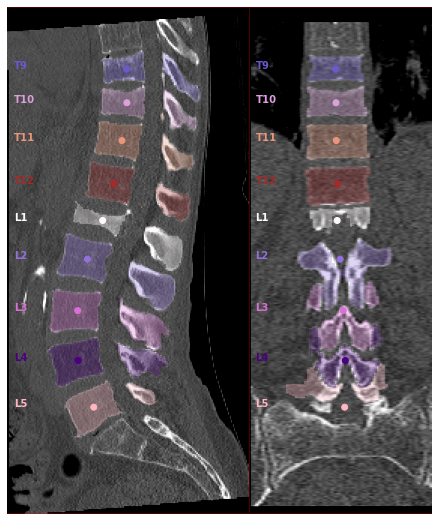

In [5]:
# get vocel data
im_np  = img_iso.get_fdata()
msk_np = msk_iso.get_fdata()


# get the mid-slice of the scan and mask in both sagittal and coronal planes

im_np_sag = im_np[:,:,int(im_np.shape[2]/2)]
im_np_cor = im_np[:,int(im_np.shape[1]/2),:]

msk_np_sag = msk_np[:,:,int(msk_np.shape[2]/2)]
msk_np_sag[msk_np_sag==0] = np.nan

msk_np_cor = msk_np[:,int(msk_np.shape[1]/2),:]
msk_np_cor[msk_np_cor==0] = np.nan

# plot 
fig, axs = create_figure(96,im_np_sag, im_np_cor)

axs[0].imshow(im_np_sag, cmap=plt.cm.gray, norm=wdw_sbone)
axs[0].imshow(msk_np_sag, cmap=cm_itk, alpha=0.3, vmin=1, vmax=64)
plot_sag_centroids(axs[0], ctd_iso, zooms)

axs[1].imshow(im_np_cor, cmap=plt.cm.gray, norm=wdw_sbone)
axs[1].imshow(msk_np_cor, cmap=cm_itk, alpha=0.3, vmin=1, vmax=64)
plot_cor_centroids(axs[1], ctd_iso, zooms)